In [39]:
from datasets import Dataset, DatasetDict, Image, Features
import pandas as pd
from PIL import Image as PILImage
import numpy as np

train_size = 4158
test_size = 945

# Generate file paths for training and testing sets
image_paths_train = [f'data/train_image_512/image_{i}.jpg' for i in range(train_size)]
label_paths_train = [f'data/train_annotation_512/annotation_{i}.png' for i in range(train_size)]
image_paths_validation = [f'data/test_image_512/image_{i}.jpg' for i in range(test_size)]
label_paths_validation = [f'data/test_annotation_512/annotation_{i}.png' for i in range(test_size)]

def create_dataset(image_paths, label_paths):
    
    dataset = Dataset.from_dict({"pixel_values": sorted(image_paths),
                                "label": sorted(label_paths)})
    dataset = dataset.cast_column("pixel_values", Image())
    dataset = dataset.cast_column("label", Image())
    return dataset


# step 1: create Dataset objects
train_dataset = create_dataset(image_paths_train, label_paths_train)
validation_dataset = create_dataset(image_paths_validation, label_paths_validation)

# step 2: create DatasetDict
dataset = DatasetDict({
     "train": train_dataset,
     "validation": validation_dataset,
     }
)

In [40]:
from torch import nn
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from transformers import SegformerForSemanticSegmentation
from transformers import TrainingArguments
# from createDataset import dataset
from torchvision.transforms import ColorJitter
from transformers import SegformerImageProcessor
from transformers import TrainingArguments
import torch
from torch import nn
import evaluate
from transformers import Trainer
import matplotlib.pyplot as plt
import matplotlib.image as pltimage

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# create 'id2label'
# id2label = {0: 'intactwall', 1: 'breakout', 2: 'faultzone', 3: 'wetspot', 4: 'unclassifycracks', 5: 'tectonictrace', 6: 'desiccation', 7: 'faultgauge'}
id2label = {0: 'intactwall', 1: 'tectonictrace', 2: 'desiccation',3: 'faultgauge', 4: 'breakout', 5: 'faultzone',}
# id2label = {0: 'intactwall', 1: 'tectonictrace', 2: 'desiccation',3: 'faultgauge', 4: 'incipientbreakout', 5: 'faultzone',6:'fullybreakout'}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

# load dataset
train_ds = dataset["train"]
test_ds = dataset["validation"]

# Image processor and augmentation
processor = SegformerImageProcessor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1) 

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained(pretrained_model_name_or_path='/home/wangrush/code/FineTune/Segformer-ep50-batch12-augment-splitarea-512/checkpoint-10400', local_files_only=True)


cuda:0


/home/wangrush/.local/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [42]:
def color_palette():
    """Color palette that maps each class to RGB values.
    
    This one is actually taken from ADE20k.
    """
    return [[4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

palette = color_palette()

In [45]:
from PIL import Image
n = 249
# im_frame = Image.open('data/test_image_512/' + f'image_{n}.jpg')
# np_frame = np.array(im_frame.getdata())
image_test = Image.open('data/test_image_512/' + f'image_{n}.jpg')
gt_seg = Image.open('data/test_annotation_512/' + f'annotation_{n}.png')

In [46]:
from torch import nn

inputs = processor(images=image_test, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image_test.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]

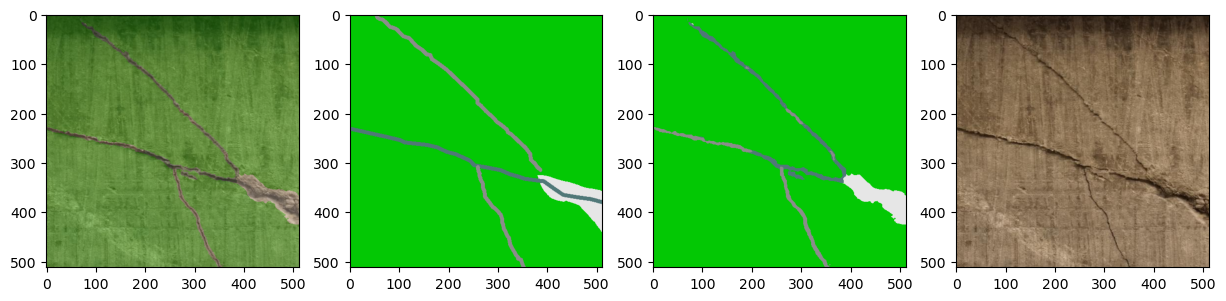

In [47]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = pred_seg.numpy()
gt_segmentation_map = np.array(gt_seg)
color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
gt_color_segmentation_map = np.zeros((gt_segmentation_map.shape[0], gt_segmentation_map.shape[1], 3), dtype=np.uint8)
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
    gt_color_segmentation_map[gt_segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]
gt_color_seg = gt_color_segmentation_map[..., ::-1]
image_arr = np.array(image_test)
img = image_arr * 0.7 + ground_truth_color_seg * 0.3
img = img.astype(np.uint8)

# plt.figure(figsize=(15, 10))
# plt.imshow(img)
# plt.imshow(gt_color_seg)
plt.figure(figsize=(15,6))
plt.subplot(1, 4, 1)
plt.imshow(img, cmap="Blues_r")
plt.subplot(1, 4, 2)
plt.imshow(gt_color_seg, cmap="Accent_r")
plt.subplot(1, 4, 3)
plt.imshow(ground_truth_color_seg, cmap="terrain_r")
plt.subplot(1, 4, 4)
plt.imshow(image_arr, cmap="twilight_shifted_r")
plt.show()

In [48]:
def mIOU(prediction, label, num_classes):
    # prediction= prediction.max(1)[1].float().cpu().numpy()
    # label = label.float().cpu().numpy() 
    
    iou_list = list()
    present_iou_list = list()
    # all_iou_list = list()

    for sem_class in range(num_classes):
        # print(sem_class)
        pred_inds = (prediction == sem_class)
        target_inds = (label == sem_class)
        if target_inds.sum().item() == 0:
            iou_now = float('nan')
            # iou_now = 0
            # all_iou_list
        else:
            # print(sem_class)
            intersection_now = (pred_inds[target_inds]).sum().item()
            union_now = pred_inds.sum().item() + target_inds.sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
        iou_list.append(iou_now)
    miou = np.mean(present_iou_list)
    return miou, iou_list

In [49]:
m_accuracy=list()
mean_IOU = list()
perClass_IOU = np.arange(8)
test_size = 945
# 1021 for test set, 5103 for whole
for i in range(test_size): 
    # image = test_ds[n]['pixel_values']
    # gt_seg = test_ds[n]['labels']
    image = Image.open('data/test_image_512/' + f'image_{i}.jpg')
    gt_seg = Image.open('data/test_annotation_512/' + f'annotation_{i}.png')
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
    )
    # Second, apply argmax on the class dimension
    pred_seg = upsampled_logits.argmax(dim=1)[0]
    pred_arr = np.array(pred_seg)
    gt_arr = np.array(gt_seg)
    acc = np.mean((pred_arr == gt_arr))
    m_accuracy.append(acc)
    m_iou,iou_list = mIOU(pred_arr,gt_arr,8)
    iou_arr = np.array(iou_list)
    mean_IOU.append(m_iou)
    # print(type(perClass_IOU))
    perClass_IOU = np.vstack([perClass_IOU,iou_arr])
    # pltimage.imsave(f'data/result_segformer/result_{i}.png', pred_arr)

In [50]:
# Print results
print("Overall mean IOU:",np.mean(mean_IOU))
print("Overall mean Acc:",np.mean(m_accuracy))
perClass_IOU = perClass_IOU[1:]
print("Per class IOU:", np.nanmean(perClass_IOU,axis = 0))

Overall mean IOU: 0.6616249746062809
Overall mean Acc: 0.9286579111896495
Per class IOU: [0.93059596 0.11920626 0.41802482 0.03839881 0.50250173 0.50986967
        nan        nan]


/tmp/ipykernel_987217/2613164239.py:5: RuntimeWarning: Mean of empty slice
  print("Per class IOU:", np.nanmean(perClass_IOU,axis = 0))


In [18]:
allresult = np.zeros((7091,48436))
width = 1024
height = 1024
for i in range(720):
    # image = test_ds_orig[n]['pixel_values']
    # gt_seg = test_ds_orig[n]['labels']
    image = Image.open('data/temporal_compare_data/230816_image_1024_overlap_20/' + f'image_{i}.jpg')
    # gt_seg = Image.open('data/annotation_overlap/' + f'annotation_{i}.png')
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
    # print(logits.shape)
    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
    )
    # Second, apply argmax on the class dimension
    pred_seg = upsampled_logits.argmax(dim=1)[0]
    pred_arr = np.array(pred_seg)
    col_num = 48436 //(width-20)
    row_num = 7091//(height-20)
    row_idx = i//col_num
    col_idx = i%col_num
    # print("Current pred unique and shape: ",np.unique(pred_arr))
    print(row_idx, col_idx)
    if col_idx<(col_num-1):
        col = col_idx*(width-20)          
    elif col_idx==(col_num-1):
        col = 48436 - width                 
    if row_idx<(row_num-1):
        row = row_idx*(height-20)
    elif row_idx==(row_num-1):
        row = 7091 - height
    if col_idx == 0 or col_idx ==(col_num-1) or row_idx ==0 or row_idx ==(row_num-1):
        allresult[int(row):int(row)+height, int(col):int(col)+width] = pred_arr
    else:
        allresult[int(row)+10:int(row)+height-10, int(col) +10:int(col)+width-10] = pred_arr[10:-10,10:-10]

    # print("All result unique:", np.unique(allresult))
    # gt_arr = np.array(gt_seg)
    # acc = np.mean((pred_arr == gt_arr))
    # m_accuracy.append(acc)
    # m_iou,iou_list = mIOU(pred_arr,gt_arr,8)
    # iou_arr = np.array(iou_list)
    # mean_IOU.append(m_iou)
    # print(type(perClass_IOU))
    # perClass_IOU = np.vstack([perClass_IOU,iou_arr])
    # pltimage.imsave(f'data/result_segformer/result_{i}.png', pred_arr)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
3 38
3 39
3 40
3 41
3 42
3 43
3 44
3 45
3 46
3 47
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17


In [26]:
np.unique(allresult)

array([0., 1., 2., 3., 5., 6.])

In [9]:
pltimage.imsave(f'data/temporal_compare_data/201113_prediction_incipient_multiscale.png', allresult)

In [14]:
# Stitch image together
allresult = np.zeros((7091,48436))
width = 512
height = 512
for i in range(5103):
    currentresult = pltimage.imread(f'data/result_segformer/result_{i}.png')
    currentlabel = currentresult[:,:,0]
    for y in range(27):
        for x in range(189):
            if x<188:
                col = x*(width/2)                
            elif x==188:
                col = 48436 - width                 
            if y<26:
                row = y*(height/2)
            elif y==26:
                row = 7091 - height
            allresult[int(row)+128:int(row)+384, int(col) +128:int(col)+384] = currentlabel[128:384,128:384]
            


KeyboardInterrupt: 

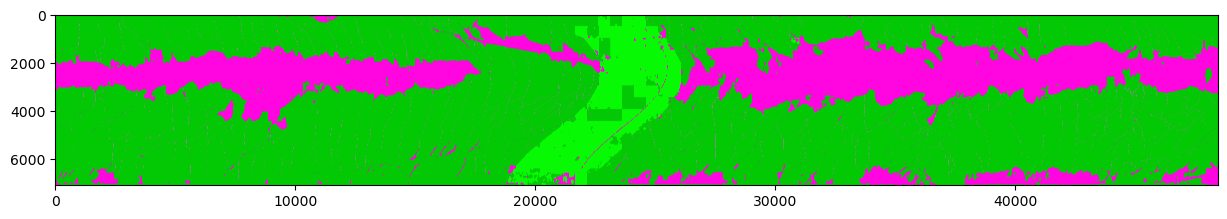

In [10]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = allresult
gt_segmentation_map = np.array(gt_seg)
color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
gt_color_segmentation_map = np.zeros((gt_segmentation_map.shape[0], gt_segmentation_map.shape[1], 3), dtype=np.uint8)
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
    # gt_color_segmentation_map[gt_segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]
# gt_color_seg = gt_color_segmentation_map[..., ::-1]
# image_arr = np.array(image_test)
# img = image_arr * 0.7 + ground_truth_color_seg * 0.3
# img = img.astype(np.uint8)

# plt.figure(figsize=(15, 10))
# plt.imshow(img)
# plt.imshow(gt_color_seg)
plt.figure(figsize=(15,6))

plt.imshow(ground_truth_color_seg, cmap="terrain_r")


In [19]:
import rasterio 
with rasterio.open("data/refined/RadiusCropped.tif") as radiusimg:
    profile = radiusimg.profile

with rasterio.open('data/temporal_compare_data/230816_prediction_incipient_1024.tif', 'w', **profile) as dst:
    dst.write(allresult.astype(rasterio.uint8), 1)

In [2]:
import pandas as pd

loss = pd.read_csv("tensorboard_loss.csv")

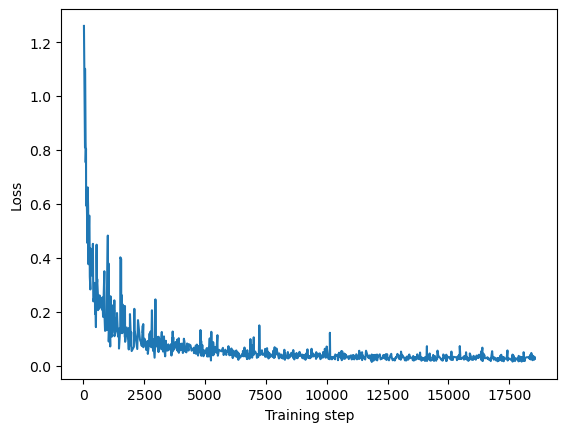

In [14]:
import numpy as np
import matplotlib.pyplot as plt
loss_arr = np.array(loss)
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.plot(loss_arr[:,1], loss_arr[:,2])
plt.savefig("loss.png")